<a href="http://agrum.org" target="blank"><img src="http://agrum.gitlab.io/theme/img/logoAgrum.png" align="left" style="height:100px"/></a><a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This pyAgrum's notebook is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.

In [1]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

import os
#the bases will be saved in "out/*.csv"
EMnomissing="out/EM_nomissing.csv"
EMmissing="out/EM_missing.csv"

### generating data with missing values (at random)

In [2]:
src=gum.fastBN("A->B<-C->D->E<-B;D->F")
gum.generateCSV(src,EMnomissing,5000,random_order=False)
src

(gum::BayesNet<double>@0x7fa71f86b000) BN{nodes: 6, arcs: 6, domainSize: 64, dim: 28}

In [3]:
import pandas as pd
import numpy as np

def add_missing(src,dst,proba):
  df=pd.read_csv(src)
  mask=np.random.choice([True, False], size=df.shape,p=[proba,1-proba])
  df.mask(mask).to_csv(dst,na_rep='?',index=False,float_format='%.0f')

gum.generateCSV(src,EMnomissing,5000,random_order=False)
add_missing(EMnomissing,EMmissing,proba=0.1)

In [4]:
print("No missing")
with open(EMnomissing,"r") as srcfile:
    for _ in range(10):
        print(srcfile.readline(),end="")
print("Missing")
with open(EMmissing,"r") as srcfile:
    for _ in range(10):
        print(srcfile.readline(),end="")

No missing
A,B,C,D,E,F
0,1,1,1,1,1
0,0,0,1,0,1
0,0,0,0,1,1
0,1,1,1,1,0
0,0,0,1,0,1
0,0,0,0,1,1
0,0,0,1,0,0
0,0,0,1,0,1
0,0,0,1,0,0
Missing
A,B,C,D,E,F
0,?,1,1,1,1
0,0,0,1,0,1
?,0,0,0,1,1
0,1,1,1,1,0
0,0,0,1,0,1
?,0,0,0,1,1
0,0,0,1,0,0
0,0,0,1,0,1
0,0,0,?,0,0


### learning with missing data

In [5]:
learner = gum.BNLearner(EMmissing,src, ["?"])
print(f"Missing values in {EMmissing} : {learner.hasMissingValues()}")

Missing values in out/EM_missing.csv : True


In [6]:
try:
  learner.learnParameters(src.dag())
except gum.MissingValueInDatabase:
  print("Learning is not possible without EM if there are some missing values.")

Learning is not possible without EM if there are some missing values.


In [7]:
learner.useEM(1e-3)
learner.useAprioriSmoothing()
print(learner)
bn=learner.learnParameters(src.dag())
print(f"# iterations : {learner.nbrIterations()}")
gnb.flow.row(gnb.getInference(src),gnb.getInference(bn))

Filename       : out/EM_missing.csv
Size           : (5000,6)
Variables      : A[2], B[2], C[2], D[2], E[2], F[2]
Induced types  : False
Missing values : True
Algorithm      : Greedy Hill Climbing
Score          : BDeu
Prior          : Smoothing  (The BDeu score already contains a different 'implicit' apriori. Therefore, the learning will probably be biased.)
Prior weight   : 1.000000
EM             : True
EM epsilon     : 0.001000

# iterations : 8


### learning with smaller error (and no smoothing)

In [8]:
learner = gum.BNLearner(EMmissing,src, ["?"])
learner.setVerbosity(True)
learner.useEM(1e-8)
bn2=learner.learnParameters(src.dag())
gnb.flow.row(gnb.getInference(src),gnb.getInference(bn2),captions=["Source",f"Estimation EM en {learner.nbrIterations()} iteration(s)"])

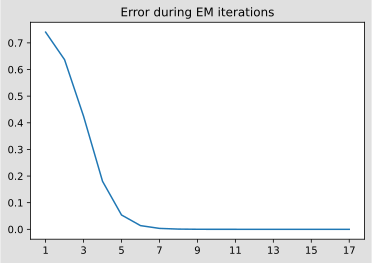

In [9]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.arange(1,1+learner.nbrIterations()),learner.history())
plt.xticks(np.arange(1, 1+learner.nbrIterations(), step=2))
plt.title("Error during EM iterations");